# Libraries

In [4]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)
training set after dropping score na:  (1485341, 9)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          

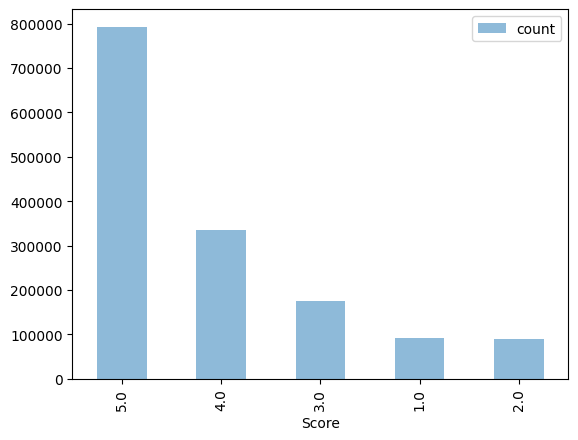


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [5]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

# Separate rows with missing scores
test_set = trainingSet[trainingSet['Score'].isnull()]   #rows missing score for testing 
trainingSet = trainingSet.dropna(subset=['Score']) 

print("training set after dropping score na: ", trainingSet.shape)
print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Save the datasets as pickle files
with open('./data/train_with_score.pkl', 'wb') as f:
    pickle.dump(trainingSet, f)
    
with open('./data/missing_score_rows.pkl', 'wb') as f:
    pickle.dump(test_set, f)
    
with open('./data/testingSet.pkl', 'wb') as f:
    pickle.dump(testingSet, f)


Clean Data

In [6]:
import numpy as np 
import re 

def clean_data(df):
    #drop NaN values from score column
    # df = df.dropna(subset=['Score']) 
    #drop irrelevant columns
    # df = df.drop(columns=['UserId'])
    # Handle missing 'ProductId'
    df['ProductId'].fillna('UnknownProduct', inplace=True)
    # Handle missing 'UserId'
    df['UserId'].fillna('UnknownUser', inplace=True)

    #handle helpfulness denominator of 0 
    df['Helpfulness'] = np.where(df['HelpfulnessDenominator'] == 0, 0, 
                                        df['HelpfulnessNumerator'] / df['HelpfulnessDenominator'])
    df['Helpfulness'] = df['Helpfulness'].fillna(0) #replace 0 with na 

    #convert unix to datetime
    df['Time'] = pd.to_datetime(df['Time'], unit='s')

    # Handle missing 'Score'
    if 'Score' in df.columns:
        # For training data, drop rows with missing 'Score'
        df = df.dropna(subset=['Score'])
        df['Score'] = df['Score'].astype(int)
    else:
        # For test data, 'Score' may not be present or is what we're predicting
        pass

    # Handle missing 'Time'
    df['Time'].fillna(df['Time'].median(), inplace=True)  # Fill with median timestamp
    df['Time'] = pd.to_datetime(df['Time'], unit='s', errors='coerce')
    # Handle any conversion errors
    df['Time'].fillna(pd.Timestamp('2000-01-01'), inplace=True)

    # Extract time features
    df['Year'] = df['Time'].dt.year
    df['Month'] = df['Time'].dt.month
    df['DayOfWeek'] = df['Time'].dt.dayofweek
    df.drop(columns=['Time'], inplace=True)

    # Fill missing values in 'Summary' and 'Text' columns
    df['Summary'].fillna('No summary', inplace=True)
    df['Text'].fillna('No text', inplace=True)

    # Apply text cleaning
    df['CleanedText'] = df['Text'].apply(lambda x: clean_text(x) if isinstance(x, str) else '')
    df['CleanedSummary'] = df['Summary'].apply(lambda x: clean_text(x) if isinstance(x, str) else '')

     # Handle missing 'Id'
    if 'Id' not in df.columns or df['Id'].isnull().any():
        # Generate unique Ids if missing
        df['Id'] = df.index

    # Check for null values
    print("Missing values after processing:")
    print(df.isnull().sum())

    return df 

def clean_text(text):
    # Remove punctuation, convert to lowercase
    text = re.sub(r'[^\w\s]', '', text.lower())
    return text


cleaned_train = clean_data(trainingSet)

X_submission = pd.merge(trainingSet, testingSet, left_on='Id', right_on='Id')
X_submission = pd.merge(
    testingSet, 
    trainingSet.drop(columns=['Score']), 
    on='Id', 
    how='left'
)

# Now, clean the merged test data
X_submission = clean_data(X_submission)
# Save the cleaned DataFrame as a pickle file
with open('./data/cleaned_train.pkl', 'wb') as f:
    pickle.dump(cleaned_train, f)

/var/folders/mw/d6jh5r755yj5xb4v20prr1g00000gn/T/ipykernel_9637/563158399.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ProductId'].fillna('UnknownProduct', inplace=True)
/var/folders/mw/d6jh5r755yj5xb4v20prr1g00000gn/T/ipykernel_9637/563158399.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Missing values after processing:
Id                        0
ProductId                 0
UserId                    0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Summary                   0
Text                      0
Score                     0
Helpfulness               0
Year                      0
Month                     0
DayOfWeek                 0
CleanedText               0
CleanedSummary            0
dtype: int64


/var/folders/mw/d6jh5r755yj5xb4v20prr1g00000gn/T/ipykernel_9637/563158399.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ProductId'].fillna('UnknownProduct', inplace=True)
/var/folders/mw/d6jh5r755yj5xb4v20prr1g00000gn/T/ipykernel_9637/563158399.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Missing values after processing:
Id                        0
Score                     0
ProductId                 0
UserId                    0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Summary                   0
Text                      0
Helpfulness               0
Year                      0
Month                     0
DayOfWeek                 0
CleanedText               0
CleanedSummary            0
dtype: int64


In [8]:
# Sample 10% of the data
subset, _ = train_test_split(
    cleaned_train,
    train_size=0.10,
    stratify=cleaned_train['Score'],
    random_state=42
)

print("Full dataset class distribution:")
print(cleaned_train['Score'].value_counts(normalize=True))
print("\nSubset class distribution:")
print(subset['Score'].value_counts(normalize=True))

Full dataset class distribution:
Score
5    0.533994
4    0.225691
3    0.118547
1    0.061393
2    0.060375
Name: proportion, dtype: float64

Subset class distribution:
Score
5    0.533992
4    0.225692
3    0.118545
1    0.061393
2    0.060377
Name: proportion, dtype: float64


# Adding Features

In [7]:
from textblob import TextBlob
import os
import numpy as np
import textstat
import pandas as pd
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer

# Define your cleaning and feature engineering functions

def clean_data(df):
    # Add your data cleaning steps here
    # Ensure to return the cleaned DataFrame
    return df

def add_features_to(df, tfidf_vectorizer=None):
    # Convert 'Text' and 'Summary' to string type
    df['Text'] = df['Text'].astype(str)
    df['Summary'] = df['Summary'].astype(str)

    # Basic text features
    df['TextLength'] = df['Text'].apply(lambda x: len(x.split()))
    df['SummaryLength'] = df['Summary'].apply(lambda x: len(x.split()))

    # Exclamation and Question Marks
    df['ExclamationMarks'] = df['Text'].apply(lambda x: x.count('!'))
    df['QuestionMarks'] = df['Text'].apply(lambda x: x.count('?'))

    # Positive and Negative Word Counts
    positive_words = {'good', 'great', 'excellent', 'amazing', 'love', 'fantastic', 'awesome'}
    negative_words = {'bad', 'terrible', 'awful', 'poor', 'worst', 'hate', 'boring'}
    df['PositiveWords'] = df['Text'].apply(lambda x: sum(word.lower() in positive_words for word in x.split()))
    df['NegativeWords'] = df['Text'].apply(lambda x: sum(word.lower() in negative_words for word in x.split()))

    # Sentiment Score
    df['SentimentScore'] = df['PositiveWords'] - df['NegativeWords']
    df['HasUppercaseWord'] = df['Text'].apply(lambda x: int(any(word.isupper() for word in x.split())))

    # Advanced Sentiment
    df['SentimentPolarity'] = df['Text'].apply(get_sentiment)

    # Vocabulary richness and review length
    df['VocabularyRichness'] = df['Text'].apply(vocabulary_richness)
    df['ReviewLength'] = df['Text'].apply(lambda x: len(x.split()))

    # Additional Textual Features
    df['AvgWordLength'] = df['Text'].apply(lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0)
    df['UniqueWordCount'] = df['Text'].apply(lambda x: len(set(x.split())))
    df['CapitalizedWordCount'] = df['Text'].apply(lambda x: sum(word.isupper() for word in x.split()))

    # Readability Score (Flesch Reading Ease)
    df['FleschReadingEase'] = df['Text'].apply(lambda x: textstat.flesch_reading_ease(x))

    # Extract TF-IDF Features
    if tfidf_vectorizer is None:
        tfidf_vectorizer = TfidfVectorizer(max_features=500)
        tfidf_matrix = tfidf_vectorizer.fit_transform(df['Text'])
    else:
        tfidf_matrix = tfidf_vectorizer.transform(df['Text'])

    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out(), index=df.index)
    df = pd.concat([df.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)

    return df, tfidf_vectorizer

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

def vocabulary_richness(text):
    words = text.split()
    unique_words = set(words)
    return len(unique_words) / len(words) if words else 0

# Check if preprocessed data exists
if os.path.exists('./data/X_train.pkl') and os.path.exists('./data/X_submission.pkl') and os.path.exists('./data/tfidf_vectorizer.pkl'):
    # Load preprocessed data
    with open('./data/X_train.pkl', 'rb') as f:
        X_train_full = pickle.load(f)
    with open('./data/X_submission.pkl', 'rb') as f:
        X_submission = pickle.load(f)
    with open('./data/tfidf_vectorizer.pkl', 'rb') as f:
        tfidf_vectorizer = pickle.load(f)
else:
    # Apply feature engineering to the cleaned training data
    X_train_full, tfidf_vectorizer = add_features_to(subset)

    # Apply feature engineering to the cleaned submission data using the same TF-IDF vectorizer
    X_submission, _ = add_features_to(X_submission, tfidf_vectorizer=tfidf_vectorizer)

    # Save the processed data
    with open('./data/X_train.pkl', 'wb') as f:
        pickle.dump(X_train_full, f)
    with open('./data/X_submission.pkl', 'wb') as f:
        pickle.dump(X_submission, f)
    with open('./data/tfidf_vectorizer.pkl', 'wb') as f:
        pickle.dump(tfidf_vectorizer, f)




# Sample + Split into training and testing set

In [8]:

# Separate features and target variable
Y = X_train_full['Score'].astype(int)
X = X_train_full.drop(columns=['Score'])

# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X,
    Y,
    test_size=0.25,
    random_state=0,
    stratify=Y
)



# Feature Selection

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pickle

# Define feature columns
features = [
    'TextLength',
    'SummaryLength',
    'ExclamationMarks',
    'QuestionMarks',
    'PositiveWords',
    'NegativeWords',
    'SentimentScore',
    'HasUppercaseWord',
    'SentimentPolarity',
    'VocabularyRichness',
    'ReviewLength',
    'AvgWordLength',
    'UniqueWordCount',
    'CapitalizedWordCount',
    'FleschReadingEase'
    # The TF-IDF features will be added dynamically and are not listed here
]

# Get TF-IDF feature names
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
# Extend the features list
features.extend(tfidf_feature_names)

# Select features from original dataset and fill any missing values
X_train_select = X_train[features].fillna(0)
X_test_select = X_test[features].fillna(0)
X_submission_select = X_submission[features].fillna(0)

# Convert 'HasUppercaseWord' to integer
for df in [X_train_select, X_test_select, X_submission_select]:
    df['HasUppercaseWord'] = df['HasUppercaseWord'].astype(int)

# Scale the subsample data
scaler = StandardScaler()
# Fit the scaler on the training data and transform
X_train_scaled = scaler.fit_transform(X_train_select)

# Transform the test and submission data
X_test_scaled = scaler.transform(X_test_select)
X_submission_scaled = scaler.transform(X_submission_select)


# Model Creation

In [10]:
from imblearn.over_sampling import SMOTE, SMOTENC, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
def balance_data(X, y, strategy='smote'):
    """
    Balance the dataset based on the specified strategy.

    Parameters:
        X (pd.DataFrame or np.array): Feature matrix.
        y (pd.Series or np.array): Target vector.
        strategy (str): Balancing strategy ('smote', 'smotenc', 'adasyn', 'undersample', 'smoteenn').

    Returns:
        X_resampled, y_resampled: Resampled feature matrix and target vector.
    """
    if strategy == 'smote':
        sampler = SMOTE(random_state=42)
    elif strategy == 'smotenc':
        categorical_features = [X.columns.get_loc('HasUppercaseWord')]  # Adjust with other categorical indices
        sampler = SMOTENC(categorical_features=categorical_features, random_state=42)
    elif strategy == 'adasyn':
        sampler = ADASYN(random_state=42)
    elif strategy == 'undersample':
        sampler = RandomUnderSampler(random_state=42)
    elif strategy == 'smoteenn':
        sampler = SMOTEENN(random_state=42)
    else:
        raise ValueError("Unknown strategy")

    X_resampled, y_resampled = sampler.fit_resample(X, y)
    return X_resampled, y_resampled


In [15]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import HistGradientBoostingClassifier

# Sample 10% of the training data for tuning
X_tune, X_test_tune, Y_tune, Y_test_tune = train_test_split(
    X_train_scaled,
    Y_train,
    train_size=0.1,
    stratify=Y_train,
    random_state=42
)

# Apply SMOTE
# Make sure `balance_data` is defined elsewhere if you intend to use it with different strategies
X_resampled, Y_resampled = balance_data(X_tune, Y_tune, strategy='adasyn')  # Change 'smoteenn' to your preference

# Parameter distribution for RandomizedSearchCV
param_distributions = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_iter': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_leaf': [1, 5, 10],
    'l2_regularization': [0.0, 0.1, 1.0],
    'max_bins': [100, 255]
}

param_optimal = {
    'learning_rate': [0.1],
    'max_iter': [300],
    'max_depth': [10],
    'min_samples_leaf': [5],
    'l2_regularization': [1.0],
    'max_bins': [100]
}

# RandomizedSearchCV with HistGradientBoostingClassifier
random_search = RandomizedSearchCV(
    estimator=HistGradientBoostingClassifier(
        class_weight='balanced',
        early_stopping=True,
        validation_fraction=0.1,
        random_state=42
    ),
    param_distributions=param_optimal,
    n_iter=20,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

# Optimal Parameters from Randomized Search:
{'min_samples_leaf': 5, 'max_iter': 300, 'max_depth': 10, 'max_bins': 100, 'learning_rate': 0.1, 'l2_regularization': 1.0}

# Fit the model on resampled data
random_search.fit(X_resampled, Y_resampled)

# Get the best model and parameters from RandomizedSearch
best_model = random_search.best_estimator_
print("Optimal Parameters from Randomized Search:")
print(random_search.best_params_)

# Evaluate on the test set
Y_test_pred = best_model.predict(X_test_scaled)

print("Classification Report:")
print(classification_report(Y_test, Y_test_pred))
print("Accuracy on testing set =", accuracy_score(Y_test, Y_test_pred))


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END l2_regularization=1.0, learning_rate=0.1, max_bins=100, max_depth=10, max_iter=300, min_samples_leaf=5; total time= 5.1min
[CV] END l2_regularization=1.0, learning_rate=0.1, max_bins=100, max_depth=10, max_iter=300, min_samples_leaf=5; total time= 5.2min
[CV] END l2_regularization=1.0, learning_rate=0.1, max_bins=100, max_depth=10, max_iter=300, min_samples_leaf=5; total time= 5.3min
Optimal Parameters from Randomized Search:
{'min_samples_leaf': 5, 'max_iter': 300, 'max_depth': 10, 'max_bins': 100, 'learning_rate': 0.1, 'l2_regularization': 1.0}
Classification Report:
              precision    recall  f1-score   support

           1       0.47      0.36      0.41      2280
           2       0.28      0.12      0.17      2242
           3       0.34      0.23      0.28      4402
           4       0.37      0.28      0.32      8381
           5       0.67      0.85      0.75     19829

    accuracy                  

# Model Evaluation

Accuracy on testing set =  0.5738945440835892


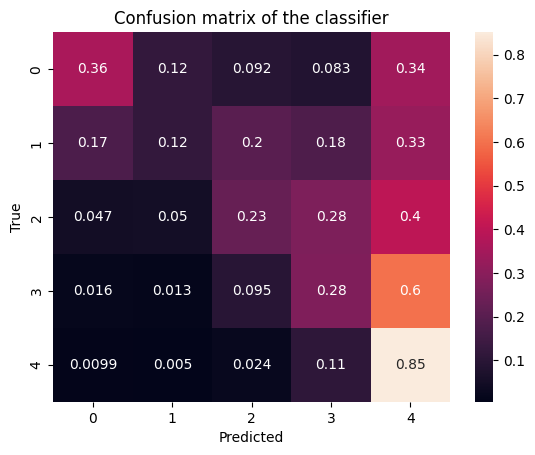

In [17]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_pred))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_pred, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [32]:
# Create the submission file
X_submission['Score'] = model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)
print(X_submission.shape)
print(X_submission_select.shape)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but HistGradientBoostingClassifier was fitted without feature names
  warnings.warn(


(212192, 524)
(212192, 515)
